# CS156 - Pipeline - First Draft

## Which Video Will I Like?

### Problem Definition

The objective of this project is to predict whether I will "like" a YouTube video based solely on its metadata before watching it. Although YouTube has its own recommendation algorithm that recommends me videos, I feel that I don't always enjoy the videos recommended by YouTube. I have a high criterion for liking a video; I only press the "like" ("thumbs up") button when I really like the video or want to watch the video again. But what exactly is the criterion? By analyzing patterns in the metadata of videos I have previously liked versus those I have watched but not liked, we aim to build a machine learning model that can forecast my likelihood of liking new videos.

### Data Components
The dataset comprises two primary categories of videos:
- **Liked Videos**: Videos that I have explicitly liked by pressing the "like" button.
- **Unliked Videos**: Videos that I have watched but did not press the "like" button.

#### Features Collected
For each video, the following features are collected:
- **Title**: The title of the video.
- **Description**: The video's description provided by the uploader.
- **Category ID**: Numeric identifier representing the video's category.
- **Duration**: Length of the video in ISO 8601 format.
- **View Count**: Total number of views the video has received.
- **Like Count**: Total number of likes the video has received.
- **Comment Count**: Total number of comments on the video.
- **Topic Categories**: Topics associated with the video.

### Data Acquisition
#### Liked Videos
- **Method**: Obtained using the YouTube Data API v3.
- **Authentication**: Authenticated via OAuth 2.0 to access my personal liked videos.
- **Process**:
  - Used the `videos().list` method with `myRating='like'` to retrieve liked videos.
  - Retrieved all available liked videos to ensure comprehensive coverage.

#### Watch History
- **Method**: Extracted from my personal YouTube watch history.
- **Source**: Downloaded using Google Takeout.
- **File**: The watch history is provided as an HTML file named `watch-history.html`.
- **Process**:
  - Parsed the HTML file using BeautifulSoup to extract video URLs.
  - Extracted video IDs from URLs using regular expressions.
  - Removed duplicate video IDs to ensure uniqueness.

#### Data Sampling
- **Unliked Videos**:
  - To balance the dataset, an equal number of unliked videos were sampled from the watch history.
  - Ensured that the unliked videos did not overlap with the liked videos.
  - Used random sampling to select unliked videos.
- **Sample Sizes**:
  - The number of unliked videos matches the number of liked videos to create a balanced dataset.
- **Data Retrieval**:
  - Fetched video details for both liked and unliked videos using the YouTube Data API v3.

The final dataset consists of an equal number of liked and unliked videos, each with detailed metadata features. This dataset will be used to train and evaluate a machine learning model capable of predicting whether I will like a video based on its attributes.

### Section 2: Data Loading and Preparation

In this section, we convert the raw data into a Python-readable format and load it into appropriate data structures for analysis and modeling. We use libraries such as pandas, re, and BeautifulSoup to parse and structure the data. OAuth 2.0 is utilized to authenticate and access personal liked videos via the YouTube Data API.

Firstly, we define functions to interact with the YouTube Data API and to parse the watch history file. The get_liked_videos() function fetches all liked videos from the user's YouTube account by iteratively calling the API and handling pagination with nextPageToken. The get_recently_watched_videos_from_html() function reads the watch-history.html file located at /Users/hcoh/Downloads/Takeout 3/YouTube and YouTube Music/history/watch-history.html and extracts video IDs using regular expressions.

After obtaining lists of liked and watched video IDs, we identify unliked videos by excluding liked video IDs from the watched video IDs. We then fetch detailed information for both liked and unliked videos using the get_videos_details() function, which calls the YouTube Data API to retrieve metadata such as title, description, category ID, duration, number of views, number of likes, number of comments, topic categories, and upload date.

The create_dataframe() function is used to organize the fetched video metadata into pandas DataFrames for both liked and unliked videos, omitting the 'tags' and 'language' fields as per the instructions. 

I am very picky when pressing a like button, so I only pressed like for 200 videos among 20,000 videos I have watched, which creates a highly imbalanced dataset with only 1% positive class samples. This imbalance can cause the machine learning model to be biased towards the majority class (unliked videos), leading to poor performance in predicting liked videos. It needs to be addressed because the model may not learn meaningful patterns associated with liked videos, reducing its ability to accurately recommend content you would enjoy. For example, the model might learn to predict all videos as unliked because doing so would yield a 99% accuracy rate. To balance the dataset, we apply undersampling to the majority class (unliked videos) using sklearn.utils.resample, ensuring that both classes have an equal number of samples. Finally, we combine the DataFrames into a single DataFrame (balanced_df), shuffle the dataset to mix the samples, and save it to a CSV file (balanced_videos.csv) for further processing.

In [366]:
# Authenfication setup for the YouTube Data API v3

from googleapiclient.discovery import build
import google_auth_oauthlib.flow

# OAuth 2.0 Authentication Setup
scopes = ["https://www.googleapis.com/auth/youtube.force-ssl"]
client_secrets_file = "../../../Desktop/client_secret.json"

# Create an OAuth flow and get credentials using the local server method
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
    client_secrets_file, scopes
)
credentials = flow.run_local_server(port=5001)

# Create a YouTube client with OAuth 2.0 credentials
youtube = build("youtube", "v3", credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=217986578119-0l6jjn9u267th7o7rh7bm2uqffaqqq96.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A5001%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=YAW1P3zqLycqmDcOT5wRyQG85T2l93&access_type=offline


In [387]:
import pandas as pd
import random
import re
from bs4 import BeautifulSoup
from sklearn.utils import resample

# Function to get liked videos from YouTube API
def get_liked_videos():
    videos = []
    next_page_token = None

    while True:
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,topicDetails",
            myRating="like",
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()
        videos.extend(response.get("items", []))
        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return videos

# Function to get video details using video IDs
def get_videos_details(video_ids):
    videos = []
    for i in range(0, len(video_ids), 50):
        try:
            request = youtube.videos().list(
                part="snippet,contentDetails,statistics,topicDetails",
                id=','.join(video_ids[i:i+50])
            )
            response = request.execute()
            videos.extend(response.get("items", []))
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
    return videos

# Function to extract video IDs from the watch history HTML file
def get_recently_watched_videos_from_html(file_path):
    # Read the HTML file
    with open(file_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f, 'lxml')

    # Find all watch history entries
    entries = soup.find_all('div', class_='mdl-grid')

    video_ids = []
    for entry in entries:
        # Find the anchor tag with the video URL
        a_tag = entry.find('a')
        if a_tag and 'youtube.com/watch' in a_tag.get('href', ''):
            url = a_tag['href']
            # Extract the video ID using regex
            match = re.search(r'v=([^&]+)', url)
            if match:
                video_id = match.group(1)
                video_ids.append(video_id)

    # Remove duplicates while preserving order
    video_ids = list(dict.fromkeys(video_ids))

    return video_ids

# Function to create a DataFrame from video items
def create_dataframe(video_items, category):
    data = []
    for item in video_items:
        snippet = item.get("snippet", {})
        content_details = item.get("contentDetails", {})
        statistics = item.get("statistics", {})
        topic_details = item.get("topicDetails", {})

        video_info = {
            "like": category,
            "title": snippet.get("title", "N/A"),
            "category_id": snippet.get("categoryId", "N/A"),
            "duration": content_details.get("duration", "N/A"),
            "view_count": int(statistics.get("viewCount", 0)),
            "like_count": int(statistics.get("likeCount", 0)),
            "comment_count": int(statistics.get("commentCount", 0)),
            "topic_categories": topic_details.get("topicCategories", []),
            "upload_date": snippet.get("publishedAt", "N/A")
        }
        data.append(video_info)
    return pd.DataFrame(data)

# Provide the path to your watch-history.html file
file_path = '/Users/hcoh/Downloads/Takeout 3/YouTube and YouTube Music/history/watch-history.html'

# Get all liked videos
liked_videos = get_liked_videos()

# Extract liked video IDs
liked_video_ids = [item['id'] for item in liked_videos]
print(f"Number of liked videos: {len(liked_video_ids)}")

# Get all recently watched video IDs
recently_watched_video_ids = get_recently_watched_videos_from_html(file_path)
print(f"Number of watched videos: {len(recently_watched_video_ids)}")

# Calculate the number of liked videos among the watched videos
liked_videos_in_watched = [vid for vid in recently_watched_video_ids if vid in liked_video_ids]
num_liked_videos_in_watched = len(liked_videos_in_watched)
print(f"Number of liked videos among the watched videos: {num_liked_videos_in_watched}")

# Filter out liked videos to get unliked videos
unliked_video_ids = [vid for vid in recently_watched_video_ids if vid not in liked_video_ids]
print(f"Number of unliked videos: {len(unliked_video_ids)}")

# Fetch details of liked videos
print(f"Fetching details for {len(liked_video_ids)} liked videos...")
liked_videos_details = get_videos_details(liked_video_ids)

# Fetch details of unliked videos
max_unliked_videos = 1000
if len(unliked_video_ids) > max_unliked_videos:
    unliked_video_ids_sample = random.sample(unliked_video_ids, max_unliked_videos)
else:
    unliked_video_ids_sample = unliked_video_ids
print(f"Fetching details for {len(unliked_video_ids_sample)} unliked videos...")
unliked_videos_details = get_videos_details(unliked_video_ids_sample)

# Create DataFrames for liked and unliked videos
liked_videos_df = create_dataframe(liked_videos_details, 1)
unliked_videos_df = create_dataframe(unliked_videos_details, 0)

print(f"Number of liked videos in DataFrame: {len(liked_videos_df)}")
print(f"Number of unliked videos in DataFrame: {len(unliked_videos_df)}")

# Combine both DataFrames
combined_df = pd.concat([liked_videos_df, unliked_videos_df], ignore_index=True)

# Apply undersampling to balance the dataset
# Separate majority and minority classes
df_majority = combined_df[combined_df.like == 0]
df_minority = combined_df[combined_df.like == 1]

# Undersample majority class
df_majority_undersampled = resample(df_majority,
                                    replace=False,    # sample without replacement
                                    n_samples=len(df_minority),  # to match minority class
                                    random_state=42)  # reproducible results

# Combine minority class with undersampled majority class
balanced_df = pd.concat([df_minority, df_majority_undersampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset size: {len(balanced_df)}")
print(balanced_df['like'].value_counts())

# Save DataFrame to CSV
balanced_df.to_csv("balanced_videos.csv", index=False)


Number of liked videos: 213
Number of watched videos: 20045
Number of liked videos among the watched videos: 212
Number of unliked videos: 19833
Fetching details for 213 liked videos...
Fetching details for 1000 unliked videos...
Number of liked videos in DataFrame: 213
Number of unliked videos in DataFrame: 966
Balanced dataset size: 426
like
0    213
1    213
Name: count, dtype: int64


In [388]:
balanced_df.head()

,like,title,category_id,duration,view_count,like_count,comment_count,topic_categories,upload_date
0,0,Jurassic World Theory: The Indominus Rex Didn'...,1,PT2M24S,153195,1532,256,"[https://en.wikipedia.org/wiki/Entertainment, ...",2020-10-27T22:02:57Z
1,1,This why Chelsea won Champions League,22,PT10S,50135587,1502270,6715,[https://en.wikipedia.org/wiki/Association_foo...,2021-09-08T16:31:35Z
2,1,LangChain Explained In 15 Minutes - A MUST Lea...,27,PT15M39S,141319,4283,92,[https://en.wikipedia.org/wiki/Technology],2023-12-13T14:00:35Z
3,1,트레이딩에 Time Series Representation 활용해보기,28,PT12M22S,5380,242,7,[https://en.wikipedia.org/wiki/Knowledge],2024-08-23T07:29:45Z
4,0,'주급 9억 원' 받던 베일과 손흥민의 조합이 기대되는 이유,17,PT13M32S,1121298,12574,1156,[https://en.wikipedia.org/wiki/Association_foo...,2020-10-04T07:45:12Z


### Section 3: Data Cleaning, Pre-processing, and Feature Engineering
In this section, we perform necessary data cleaning, pre-processing, and feature engineering to prepare the data for modeling. We also conduct exploratory data analysis to understand the distributions and relationships within the data.

We start by loading the balanced dataset from the CSV file into a pandas DataFrame. To handle missing values and ensure consistency, we check for missing data in critical fields such as view_count, like_count, and duration. Missing numerical values are replaced with zeros or appropriate statistical measures, and rows with missing essential data are dropped if necessary.

Next, we convert data types to facilitate analysis. The duration field, originally in ISO 8601 format (e.g., "PT15M33S"), is converted to total seconds using the iso_duration_to_seconds() function. The upload_date field is parsed into datetime objects, allowing us to extract date components if needed.

For feature engineering, we extract meaningful information from existing data. The topic_categories field, which contains lists of URLs indicating the video's topics, is processed to extract the last segment of each URL, providing concise topic labels. We handle cases where topic_categories might be stored as strings by converting them to lists before extraction.

We also map the category_id numeric codes to descriptive category names using a predefined mapping dictionary. This improves the interpretability of the data and facilitates analysis of video categories.

By completing these steps, we ensure that the dataset is clean, well-structured, and enriched with features that enhance the predictive power of our models.

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load the data from CSV
df = pd.read_csv("balanced_videos.csv")

# Convert 'upload_date' to datetime
df['upload_date'] = pd.to_datetime(df['upload_date'], errors='coerce')

# Convert ISO 8601 duration format to seconds
def iso_duration_to_seconds(duration):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', duration)
    if not match:
        return 0
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    seconds = int(match.group(3)) if match.group(3) else 0
    return hours * 3600 + minutes * 60 + seconds

df['duration_seconds'] = df['duration'].apply(iso_duration_to_seconds)

# Extract the last word from each URL in the 'topic_categories' list
def extract_last_words(topic_list):
    if isinstance(topic_list, list):
        last_words = []
        for url in topic_list:
            # Extract the last word from the URL
            match = re.search(r'/([^/]+)$', url)
            if match:
                last_words.append(match.group(1))
        return ' '.join(last_words)
    return ''

# Convert 'topic_categories' from string representation to list if necessary
df['topic_categories'] = df['topic_categories'].apply(
    lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Apply the function to extract last words
df['topic_categories_extracted'] = df['topic_categories'].apply(extract_last_words)

# Convert 'category_id' to strings and map to category names
category_mapping = {
    '1': 'Film & Animation',
    '2': 'Autos & Vehicles',
    '10': 'Music',
    '15': 'Pets & Animals',
    '17': 'Sports',
    '18': 'Short Movies',
    '19': 'Travel & Events',
    '20': 'Gaming',
    '21': 'Videoblogging',
    '22': 'People & Blogs',
    '23': 'Comedy',
    '24': 'Entertainment',
    '25': 'News & Politics',
    '26': 'Howto & Style',
    '27': 'Education',
    '28': 'Science & Technology',
    '29': 'Nonprofits & Activism'
}

df['category_id'] = df['category_id'].astype(str).map(category_mapping).fillna(df['category_id'])

# Drop rows with NaNs or Infs in all relevant columns
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=df.select_dtypes(include=[np.number]).columns)

print("Data cleaned: removed rows with NaNs or Infs in all relevant columns.")

df

Data cleaned: removed rows with NaNs or Infs in all relevant columns.


,like,title,category_id,duration,view_count,like_count,comment_count,topic_categories,upload_date,duration_seconds,topic_categories_extracted
0,0,Jurassic World Theory: The Indominus Rex Didn'...,Film & Animation,PT2M24S,153195,1532,256,"[https://en.wikipedia.org/wiki/Entertainment, ...",2020-10-27 22:02:57+00:00,144,Entertainment Film
1,1,This why Chelsea won Champions League,People & Blogs,PT10S,50135587,1502270,6715,[https://en.wikipedia.org/wiki/Association_foo...,2021-09-08 16:31:35+00:00,10,Association_football Sport
2,1,LangChain Explained In 15 Minutes - A MUST Lea...,Education,PT15M39S,141319,4283,92,[https://en.wikipedia.org/wiki/Technology],2023-12-13 14:00:35+00:00,939,Technology
3,1,트레이딩에 Time Series Representation 활용해보기,Science & Technology,PT12M22S,5380,242,7,[https://en.wikipedia.org/wiki/Knowledge],2024-08-23 07:29:45+00:00,742,Knowledge
4,0,'주급 9억 원' 받던 베일과 손흥민의 조합이 기대되는 이유,Sports,PT13M32S,1121298,12574,1156,[https://en.wikipedia.org/wiki/Association_foo...,2020-10-04 07:45:12+00:00,812,Association_football Sport
...,...,...,...,...,...,...,...,...,...,...,...
421,1,1년간 격주로 다녀오고 단골된 ‘오사카 맛집 8곳’,Travel & Events,PT9M25S,409330,11845,164,"[https://en.wikipedia.org/wiki/Food, https://e...",2023-11-12 08:00:24+00:00,565,Food Lifestyle_(sociology) Tourism
422,1,Are You Leaving Room For Wonder? | Taylor Hughes,People & Blogs,PT59S,35905238,2217351,8316,[https://en.wikipedia.org/wiki/Entertainment],2024-03-26 02:19:15+00:00,59,Entertainment
423,0,왔다… 떡볶이 네고 [네고왕2] Ep.9,Comedy,PT21M4S,4150153,76180,10544,"[https://en.wikipedia.org/wiki/Entertainment, ...",2021-04-16 09:30:18+00:00,1264,Entertainment Humour Television_program
424,0,몽골 사람이랑 한국사람이 닮으면 생기는 일,People & Blogs,PT29S,4930815,86929,1159,[],2024-03-17 05:51:56+00:00,29,


### Exploratory data analysis & feature engineering
Now that we have the dataset ready, let's explore the dataset. 

Using boxplots with a logarithmic scale to compare the distributions of view_count, like_count, and comment_count between liked (like = 1) and not liked (like = 0) videos. This helps reveal any differences or patterns in these metrics across the two categories.

Descriptive Statistics: Calculating and displaying descriptive statistics (such as count, mean, standard deviation, min, max, and quartiles) for these metrics grouped by the like status. This provides quantitative insights into how these variables differ between liked and not liked videos.

/var/folders/bj/v7yqq2jx251dklc4d7nj2vyc0000gn/T/ipykernel_63678/2213393932.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Not Liked', 'Liked'])
/var/folders/bj/v7yqq2jx251dklc4d7nj2vyc0000gn/T/ipykernel_63678/2213393932.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Not Liked', 'Liked'])
/var/folders/bj/v7yqq2jx251dklc4d7nj2vyc0000gn/T/ipykernel_63678/2213393932.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Not Liked', 'Liked'])
/var/folders/bj/v7yqq2jx251dklc4d7nj2vyc0000gn/T/ipykernel_63678/2213393932.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocato

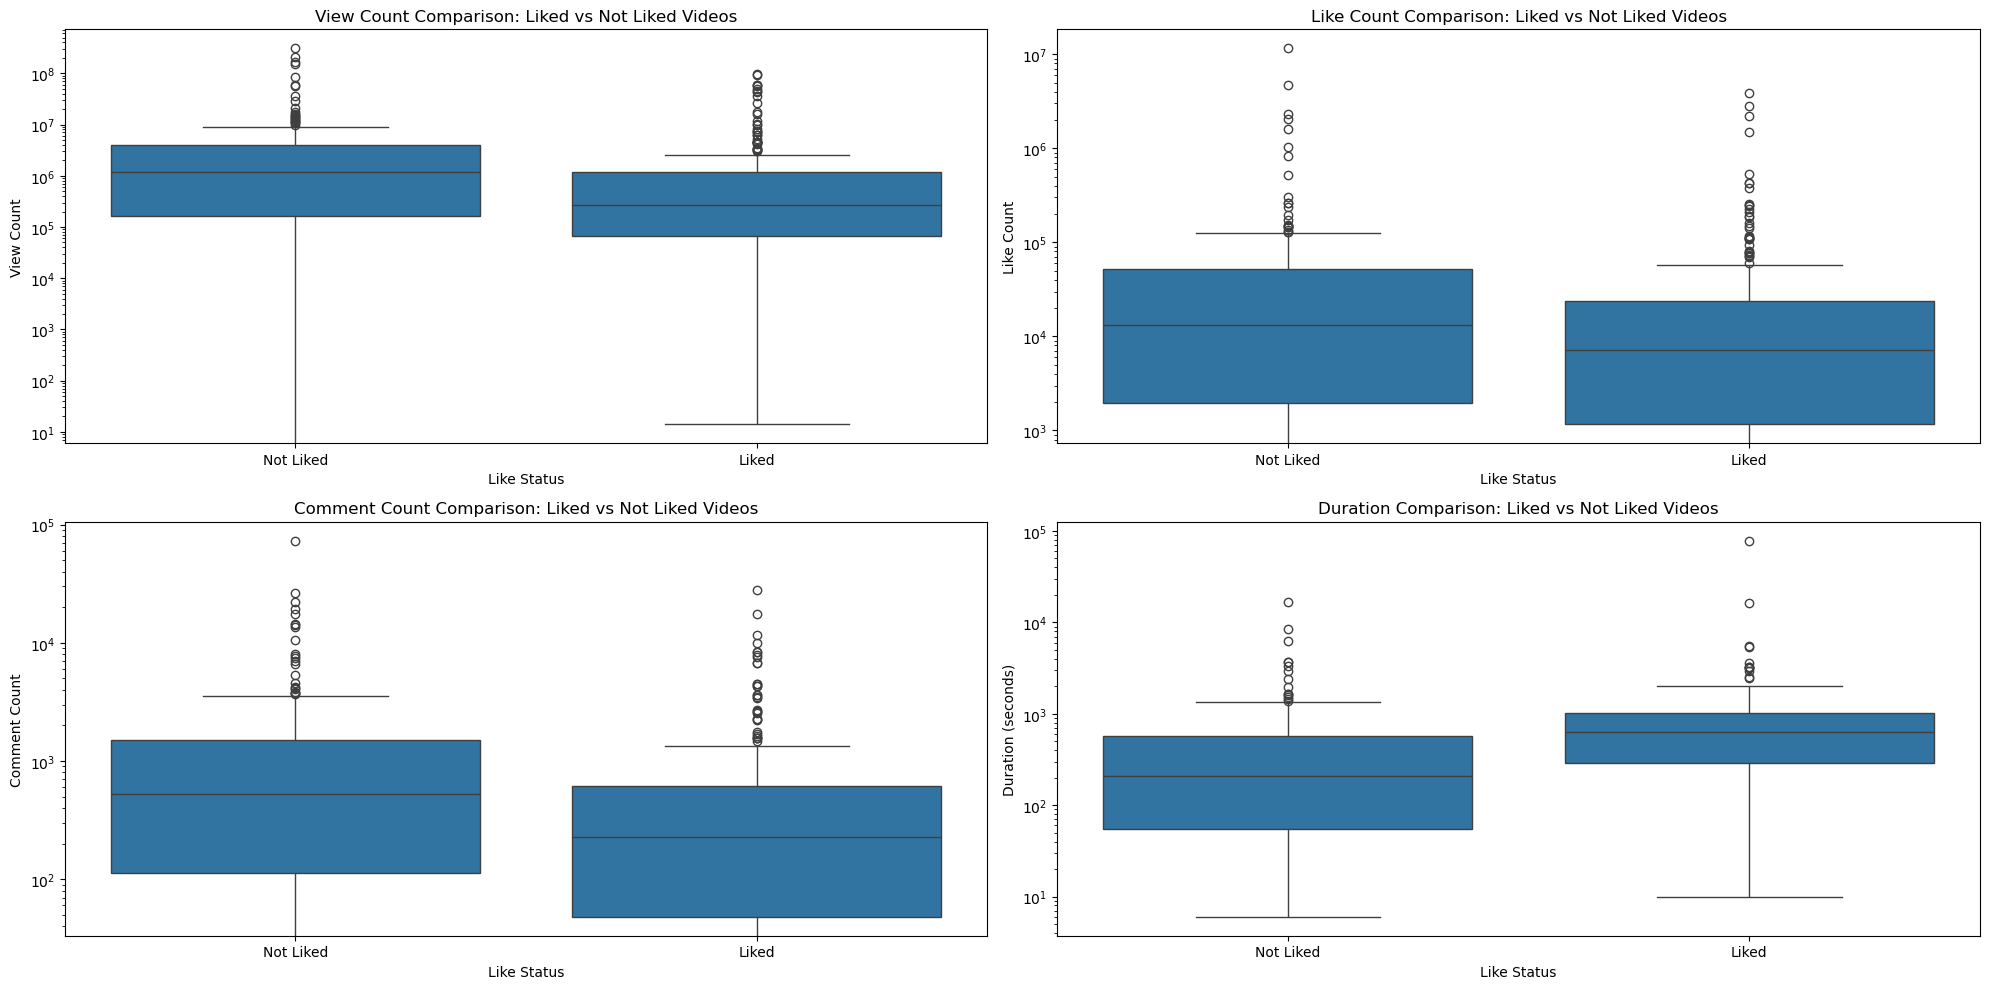


Descriptive Statistics by Like Status:
        view_count                like_count          comment_count         \
              mean     median           mean   median          mean median   
like                                                                         
0     7.606540e+06  1190818.0  148836.352113  13345.0   1962.948357  527.0   
1     3.766579e+06   268812.0   80924.023474   7158.0   1034.023474  228.0   

     duration_seconds         
                 mean median  
like                          
0          563.920188  208.0  
1         1217.638498  628.0  


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize data side by side
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Compare view counts of liked and not liked videos
sns.boxplot(ax=axes[0, 0], x="like", y="view_count", data=df)
axes[0, 0].set_title("View Count Comparison: Liked vs Not Liked Videos")
axes[0, 0].set_xlabel("Like Status")
axes[0, 0].set_ylabel("View Count")
axes[0, 0].set_yscale("log")  # Use log scale to handle wide range of view counts
axes[0, 0].set_xticklabels(['Not Liked', 'Liked'])

# Compare like counts of liked and not liked videos
sns.boxplot(ax=axes[0, 1], x="like", y="like_count", data=df)
axes[0, 1].set_title("Like Count Comparison: Liked vs Not Liked Videos")
axes[0, 1].set_xlabel("Like Status")
axes[0, 1].set_ylabel("Like Count")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xticklabels(['Not Liked', 'Liked'])

# Compare comment counts of liked and not liked videos
sns.boxplot(ax=axes[1, 0], x="like", y="comment_count", data=df)
axes[1, 0].set_title("Comment Count Comparison: Liked vs Not Liked Videos")
axes[1, 0].set_xlabel("Like Status")
axes[1, 0].set_ylabel("Comment Count")
axes[1, 0].set_yscale("log")
axes[1, 0].set_xticklabels(['Not Liked', 'Liked'])

# Compare duration of liked and not liked videos
sns.boxplot(ax=axes[1, 1], x="like", y="duration_seconds", data=df)
axes[1, 1].set_title("Duration Comparison: Liked vs Not Liked Videos")
axes[1, 1].set_xlabel("Like Status")
axes[1, 1].set_ylabel("Duration (seconds)")
axes[1, 1].set_yscale("log")
axes[1, 1].set_xticklabels(['Not Liked', 'Liked'])

plt.tight_layout()
plt.show()

# Descriptive statistics comparison
print("\nDescriptive Statistics by Like Status:")
print(df.groupby("like")[["view_count", "like_count", "comment_count", "duration_seconds"]].agg(['mean', 'median']))

On average, videos that were not liked (mean: ~7.6 million views) have significantly more views compared to liked videos (mean: ~3.8 million views). The median view count for not liked videos (1.19 million) is also much higher than for liked videos (268,812 views), indicating that more popular videos are less likely to be liked.
Similar trait can be seen in number of likes and comments, where the videos I like tend to have fewer likes and comments. 
Duration (in seconds) for liked videos was longer than duration for unliked videos by more than 100%, which is a significant difference. 

One interesting trait that can be seen here is that the differences in the number of likes and comments between the two groups are much smaller than that of view count. While the median view count in 'not liked' videos was more than four times greater than that of 'liked' videos, the differences in 'like_count' and 'comment_count' were roughly half as pronounced. This suggests that while view count might indicate overall popularity, it may not be as indicative of personal engagement or quality as likes and comments are.
To better capture the engagement level, it might be beneficial to create new features, 'like_ratio' and 'comment_ratio,' which divide the number of likes and comments by the number of views. These new features can provide a more standardized measure of engagement, indicating how effectively a video attracts likes or comments relative to its viewership. This could offer more nuanced insights into the quality or appeal of a video, as a high 'like_ratio' or 'comment_ratio' might reflect higher viewer satisfaction or engagement regardless of raw view count. Thus, these ratios could be powerful predictors in determining whether a video will be liked.

Code cells below calculate correlation among the origianl variables, create two new ratio variables, and calculate correlation in new set of variables. 


In [5]:
# Calculate the correlation matrix for view_count, like_count, and comment_count
correlation_matrix = df[['view_count', 'like_count', 'comment_count', 'duration_seconds']].corr()

# Display the correlation matrix
print("Correlation between number of views, likes, comments, and duration:")
print(correlation_matrix)

Correlation between number of views, likes, comments, and duration:
                  view_count  like_count  comment_count  duration_seconds
view_count          1.000000    0.825233       0.432680         -0.037380
like_count          0.825233    1.000000       0.425203         -0.028665
comment_count       0.432680    0.425203       1.000000         -0.027651
duration_seconds   -0.037380   -0.028665      -0.027651          1.000000


In [6]:
# Calculate like_ratio and comment_ratio
df['like_ratio'] = df['like_count'] / df['view_count']
df['comment_ratio'] = df['comment_count'] / df['view_count']

# Calculate the correlation matrix for view_count, like_ratio, and comment_ratio
correlation_matrix = df[['view_count', 'like_ratio', 'comment_ratio']].corr()

# Display the correlation matrix
print("Correlation between number of views, like ratio, and comment ratio:")
print(correlation_matrix)

Correlation between number of views, like ratio, and comment ratio:
               view_count  like_ratio  comment_ratio
view_count       1.000000   -0.031297      -0.092708
like_ratio      -0.031297    1.000000       0.311435
comment_ratio   -0.092708    0.311435       1.000000


The correlation matrix above supports my reasoning; videos with more views will naturally tend to have more likes and comments, but that does not necessarily mean they are more engaging. The correlation coefficient between views and likes is 0.825, indicating a strong positive correlation. This suggests that as the number of views increases, the number of likes also tends to increase significantly. On the other hand, the correlation coefficient between view and like_ratio is -0.031, which is a very weak negative relationship. 

These correlations indicate that while the raw counts of likes and comments are correlated with view counts, the ratios (which normalize by the number of views) tell a different story. The weak or negligible correlation between view count and the ratios suggests that the quality or engagement of a video, as measured by these ratios, does not necessarily depend on its popularity. The moderate correlation between like ratio and comment ratio indicates that more engaging content tends to both attract likes and prompt comments, regardless of overall popularity.

Now, let's compare the like and comment ratios of our two groups. Would the videos I pressed like have higher like and comment ratios?

In [7]:
# Replace NaN and Inf values in ratios with 0
df.replace({'like_ratio': [np.inf, -np.inf, np.nan], 'comment_ratio': [np.inf, -np.inf, np.nan]}, 0, inplace=True)

# Compare the ratios of like and unlike groups
like_group = df[df['like'] == 1][['like_ratio', 'comment_ratio']].agg(['mean', 'median'])
unlike_group = df[df['like'] == 0][['like_ratio', 'comment_ratio']].agg(['mean', 'median'])

print("\nMean & meadian for Like Group:")
print(like_group)

print("\nMean & meadian for Unlike Group:")
print(unlike_group)


Mean & meadian for Like Group:
        like_ratio  comment_ratio
mean      0.029791       0.001544
median    0.025851       0.000652

Mean & meadian for Unlike Group:
        like_ratio  comment_ratio
mean      0.015617       0.001271
median    0.012092       0.000477


The numbers above aligns with the intuition that I am more likely to press like for videos with higher like & comment ratios. The "like" group's mean and median like_ratio were about twice as higher as that of "unlike" group. The comment ratio was also higher in the "like" group, but the difference was relatively small. Additionally, the correlation between like ratio and comment ratio indicates some redundancy. Therefore, we will include only the like ratio in our model as it provides a clearer distinction between the two groups and reduces feature overlap, enhancing model efficiency.

To explore the category data, we separate the dataset into liked and unliked videos. We then calculate the frequency of each video category within these groups and visualize the distributions using histograms. The side-by-side histograms illustrate the category preferences in liked versus unliked videos.

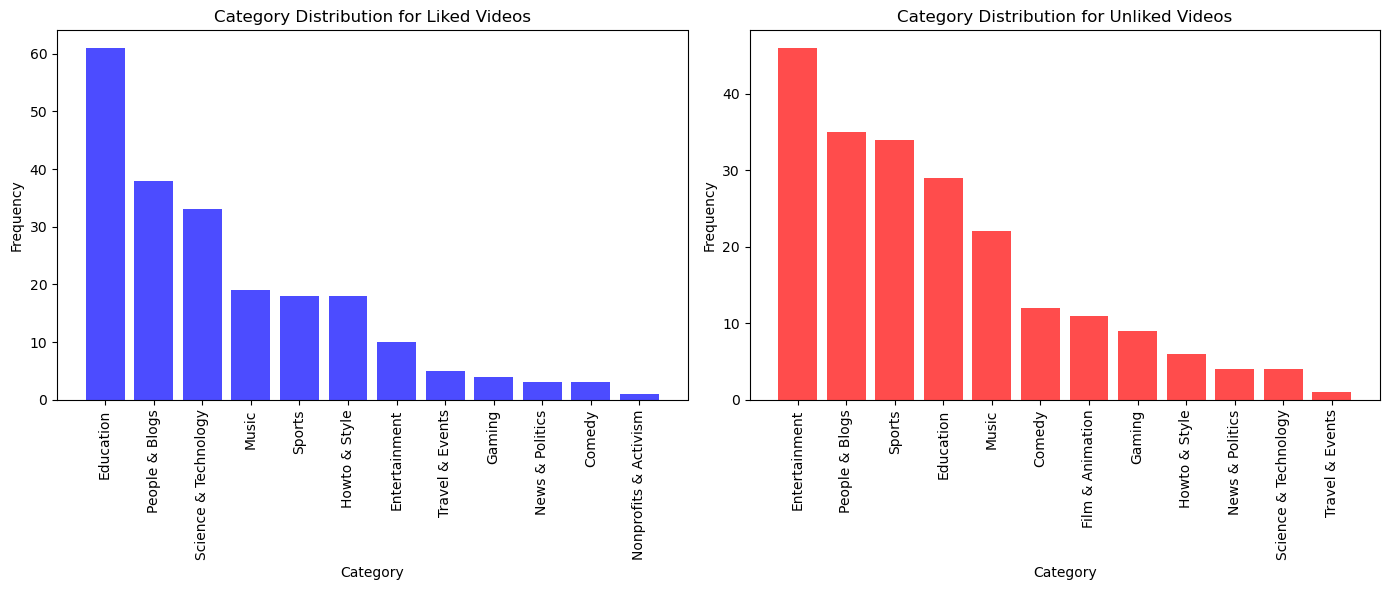

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate liked and unliked videos
liked_group = df[df['like'] == 1]
unliked_group = df[df['like'] == 0]

# Rank categories by frequency
liked_category_counts = liked_group['category_id'].value_counts()
unliked_category_counts = unliked_group['category_id'].value_counts()

liked_categories_sorted = liked_category_counts.index
unliked_categories_sorted = unliked_category_counts.index

# Visualize category distribution for liked and unliked videos
plt.figure(figsize=(14, 6))

# Histogram for liked videos
plt.subplot(1, 2, 1)
plt.bar(liked_categories_sorted, liked_category_counts[liked_categories_sorted], color='blue', alpha=0.7)
plt.title("Category Distribution for Liked Videos")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

# Histogram for unliked videos
plt.subplot(1, 2, 2)
plt.bar(unliked_categories_sorted, unliked_category_counts[unliked_categories_sorted], color='red', alpha=0.7)
plt.title("Category Distribution for Unliked Videos")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

The histogram above reveals insights into my personal viewing habits and potential patterns that could inform the modeling process.
"Entertainment" has the second highest frequency among unliked videos, but it is only 7th most popular category in liked videos. 
On the other hand, "Education" is the most frequent category in the liked videos, but it is only 5th most frequent category in the watched videos without likes. Similar pattern can be found for "Science & Technology".
The distribution suggests a stronger likelihood of liking educational and technology-related videos. Intuitively, it seems like I tend to press like for video that I found helpful or meaningful. This insight can help in building a machine learning model by giving more weight to categories like Education for predicting likes.

### Extracting and Cleaning Text Data 

To prepare the textual data for machine learning models, it was crucial to first extract and clean the text data from the YouTube video metadata. This process involved working with video titles and topic categories, which contain a mixture of useful information and irrelevant content. We started by tokenizing the text using the NLTK library, which involves breaking down sentences into individual words (tokens). This allowed us to handle each word separately, making it easier to analyze patterns in the data. During this step, we also removed stop words—common words such as "the," "and," and "is"—that do not contribute much value to the understanding of the content. Additionally, only alphanumeric tokens were retained, further reducing noise in the dataset and ensuring that only meaningful words were kept for analysis.

After tokenizing and filtering the text, we applied **CountVectorizer** from scikit-learn to convert the cleaned text into a structured format suitable for machine learning. Specifically, CountVectorizer transforms the words into a matrix of token counts, effectively representing each word's frequency within the dataset. This transformation was applied separately to both video titles and topic categories, creating distinct feature sets that can be used in our models. We then combined the numeric features, such as view count and like ratio, with the text features to form a comprehensive feature set for model training. This combination ensures that both the metadata and the content descriptions contribute to the predictive power of our classification models.

In [9]:
# Download necessary NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Define the target variable
target = 'like'

# NLP with title and topic categories
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Set up stop words
stop_words = set(stopwords.words('english'))

def tokenize_and_filter(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

# Apply tokenization to title and topic categories separately
df['tokenized_title'] = df['title'].astype(str).apply(tokenize_and_filter)
df['tokenized_topic'] = df['topic_categories_extracted'].astype(str).apply(tokenize_and_filter)

# Convert title and topic categories extracted to separate features
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_title = CountVectorizer(stop_words='english')
vectorizer_topic = CountVectorizer(stop_words='english')

# Convert title to feature matrix
title_features = vectorizer_title.fit_transform(df['title'].astype(str))

# Convert topic categories extracted to feature matrix
topic_features = vectorizer_topic.fit_transform(df['topic_categories_extracted'].astype(str))

# Count word frequencies for 'like' and 'not like' groups
liked_words_title = df[df['like'] == 1]['tokenized_title'].sum()
unliked_words_title = df[df['like'] == 0]['tokenized_title'].sum()
liked_words_topic = df[df['like'] == 1]['tokenized_topic'].sum()
unliked_words_topic = df[df['like'] == 0]['tokenized_topic'].sum()

liked_word_freq_title = Counter(liked_words_title)
unliked_word_freq_title = Counter(unliked_words_title)
liked_word_freq_topic = Counter(liked_words_topic)
unliked_word_freq_topic = Counter(unliked_words_topic)

# Get the most common words in each group for titles and topics
most_common_liked_title = liked_word_freq_title.most_common(10)
most_common_unliked_title = unliked_word_freq_title.most_common(10)
most_common_liked_topic = liked_word_freq_topic.most_common(10)
most_common_unliked_topic = unliked_word_freq_topic.most_common(10)

# Print most common words
print("\nMost Common Words in Liked Videos (Title):")
print(most_common_liked_title)
print("\nMost Common Words in Not Liked Videos (Title):")
print(most_common_unliked_title)
print("\nMost Common Words in Liked Videos (Topic):")
print(most_common_liked_topic)
print("\nMost Common Words in Not Liked Videos (Topic):")
print(most_common_unliked_topic)


Most Common Words in Liked Videos (Title):
[('python', 17), ('learn', 10), ('방법', 10), ('2024', 8), ('5', 7), ('learning', 7), ('이유', 6), ('tutorial', 6), ('오사카', 5), ('안', 5)]

Most Common Words in Not Liked Videos (Title):
[('vs', 9), ('shorts', 6), ('진짜', 6), ('이', 6), ('live', 5), ('이유', 4), ('손흥민', 4), ('더', 4), ('2024', 4), ('baby', 4)]

Most Common Words in Liked Videos (Topic):
[('knowledge', 71), ('technology', 45), ('sociology', 33), ('music', 23), ('food', 16), ('sport', 13), ('health', 12), ('society', 11), ('tourism', 6), ('business', 6)]

Most Common Words in Not Liked Videos (Topic):
[('entertainment', 42), ('sport', 38), ('music', 28), ('knowledge', 17), ('sociology', 17), ('film', 16), ('food', 8), ('society', 8), ('humour', 7), ('technology', 6)]


[nltk_data] Downloading package punkt to /Users/hcoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hcoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The frequencies of most common words are displayed in histogram below. The result shows similar pattern with the category analysis above; for the liked videos, most common words in the titles are "Python", "learn", and "방법" (it means 'method' or 'how to') and most common words in the topics are "knowledge" and "technology". On the other group, most common words seem more casual and entertaining: 'vs', 'shorts' for titles and 'entertainment', 'sport' for topics. 'Entertainment' is not even on the top 10 topic list in liked videos. This clear distinction in the representation of textual features means that this text data will be effectively utilized by the model.

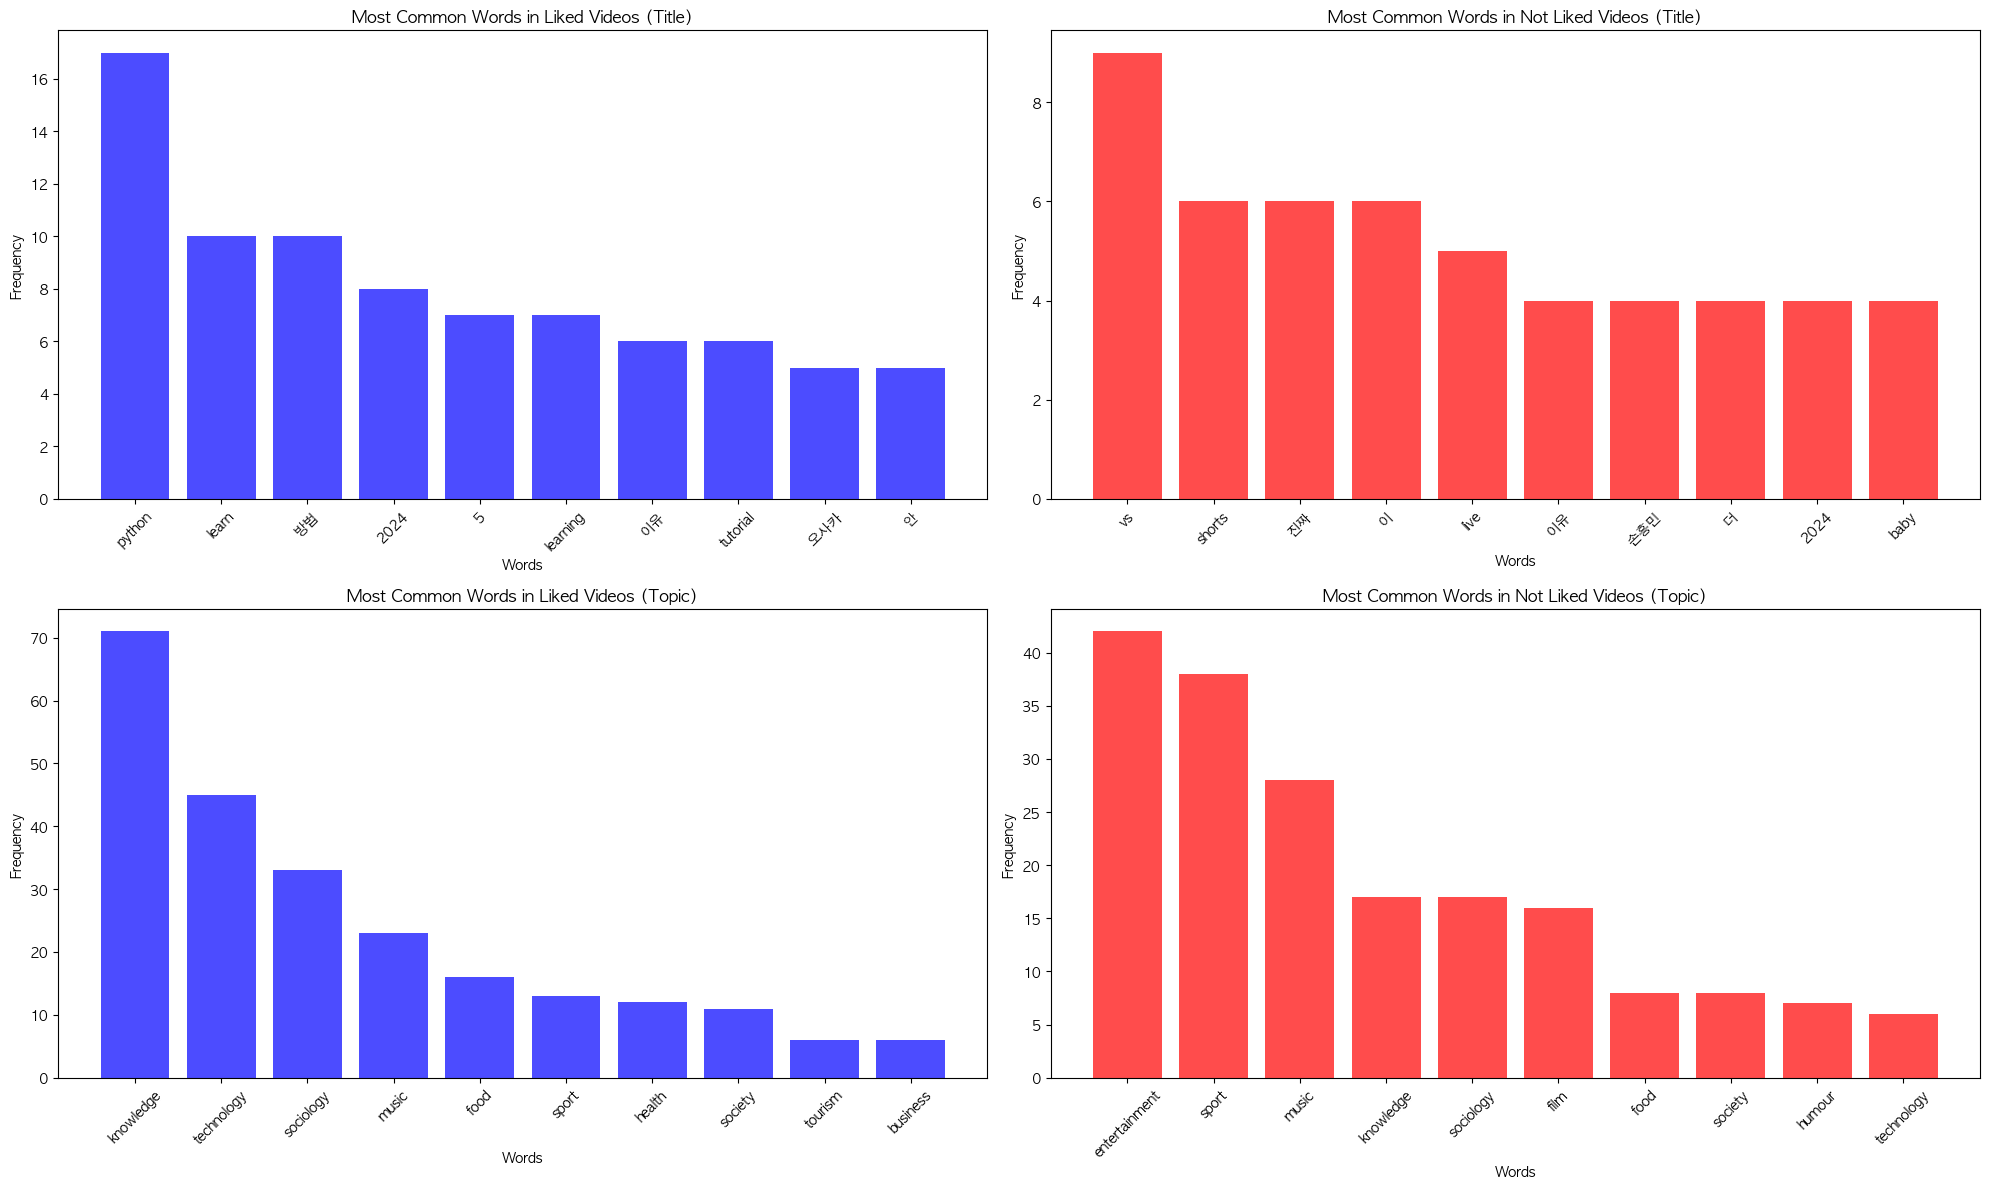

In [48]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Function to set Korean font
def set_korean_font():
    # Find a font that supports Korean
    korean_fonts = [font for font in fm.findSystemFonts() if 'Nanum' in font or 'AppleGothic' in font or 'Malgun' in font]
    if korean_fonts:
        plt.rcParams['font.family'] = fm.FontProperties(fname=korean_fonts[0]).get_name()

# Set Korean font
set_korean_font()

# Visualization of most common words
plt.figure(figsize=(20, 12))

# Title - Liked
plt.subplot(2, 2, 1)
plt.bar(*zip(*most_common_liked_title), color='blue', alpha=0.7)
plt.title("Most Common Words in Liked Videos (Title)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Title - Not Liked
plt.subplot(2, 2, 2)
plt.bar(*zip(*most_common_unliked_title), color='red', alpha=0.7)
plt.title("Most Common Words in Not Liked Videos (Title)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Topic - Liked
plt.subplot(2, 2, 3)
plt.bar(*zip(*most_common_liked_topic), color='blue', alpha=0.7)
plt.title("Most Common Words in Liked Videos (Topic)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Topic - Not Liked
plt.subplot(2, 2, 4)
plt.bar(*zip(*most_common_unliked_topic), color='red', alpha=0.7)
plt.title("Most Common Words in Not Liked Videos (Topic)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Section 4

For this project, we will use a classification analysis to predict whether a video will be liked based on its metadata and textual features. The goal is to classify each video as either "liked" or "not liked," making this a binary classification problem. 

The features we will be using in this analysis are:
- Number of Views: The popularity of a video.
- Like Ratio: The number of likes relative to the number of views.
- Duration of Video: The length of the video in seconds.
- Category ID: The category of the video, such as "Education" or "Music".
- Text Features: Words from the video title and topic categories extracted.

We will split the data into training and test sets, where 80% of the data is used for training the model and 20% is used for testing its performance. The training set helps the model learn patterns, while the test set provides an unbiased evaluation of the model's predictive ability on unseen data.

In [11]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack
import pandas as pd
import numpy as np

# One-hot encode the categorical 'category_id' column
one_hot_encoder = OneHotEncoder()
category_encoded = one_hot_encoder.fit_transform(df[['category_id']])

# Define numeric features for Logistic Regression
X_numeric = df[['view_count', 'like_ratio', 'duration_seconds']]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combine numeric and encoded categorical features for Logistic Regression
X_combined = hstack([X_numeric_scaled, category_encoded])

# Split the dataset for Logistic Regression
y = df['like']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Prepare text features for Naive Bayes
vectorizer_title = CountVectorizer(stop_words='english')
vectorizer_topic = CountVectorizer(stop_words='english')

# Convert title and topic categories to feature matrices
title_features = vectorizer_title.fit_transform(df['title'].astype(str))
topic_features = vectorizer_topic.fit_transform(df['topic_categories_extracted'].astype(str))

# Combine text features for Naive Bayes
X_nb = hstack([title_features, topic_features])

# Split text features into training and test sets for Naive Bayes
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_nb, y, test_size=0.2, random_state=42
)

# Print confirmation that data has been split for Logistic Regression and Naive Bayes
print("Data has been successfully split into training and test sets for Logistic Regression and Naive Bayes models.")

Data has been successfully split into training and test sets for Logistic Regression and Naive Bayes models.


## Section 5: Model Selection

We will create three machine learning models for this task: Logistic Regression, Naive Bayes, and a Voting Classifier. Logistic Regression will serve as a baseline model, while Naive Bayes will be used for text-based classification, taking advantage of its efficiency in handling high-dimensional data. If both models perform well, we will create a Voting Classifier to combine the predictions from Logistic Regression and Naive Bayes, which is an ensemble learning technique that makes a final decision based on combined predictions. 



### Model 1: Logistic regression
For my first model, I am going to use logistic regression to classify liked and unliked videos. The features I will use include the number of views, like ratio, duration of the video, and category ID. Logistic regression is a good starting point for binary classification problems, and it will help me establish a baseline performance for this task. By using these features, I aim to understand how different aspects of a video's metadata contribute to whether I like it or not.

Logistic regression is well-suited for binary classification tasks like this one because it provides a probabilistic approach to predicting categorical outcomes. In this case, it will estimate the probability that a given video will be liked based on the input features. The logistic regression model uses a linear combination of the input features and passes it through a sigmoid function, which outputs a value between 0 and 1. This output value can be interpreted as the probability of a positive class (i.e., liking the video).

The math behind logistic regression involves computing a weighted sum of the input features and adding a bias term. Mathematically, this can be represented as:

$$ z = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b $$

where \( w_i \) are the weights, \( x_i \) are the input features, and \( b \) is the bias term. The value \( z \) is then passed through the sigmoid function:

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

The sigmoid function transforms \( z \) into a probability value between 0 and 1. The model then classifies the video as "liked" or "not liked" based on a threshold value (commonly 0.5). Logistic regression is also advantageous because it provides interpretability—each weight represents the contribution of the corresponding feature to the likelihood of liking a video, making it easy to understand the impact of different features.

Code cell below splits the data into training and test set with 80-20 split using sklearn's train_test_split. The training set is used to fit the logistic regression model, while the test set is used to evaluate its performance. This split ensures that we can measure how well the model generalizes to new, unseen data.
The random_state=42 parameter is used to ensure reproducibility of the data split. By fixing the random seed, the train-test split will be consistent every time the code is run, making it easier to compare results. The choice of 42 is arbitrary, following the convention in the data science community.

#### Pseudocode 
Logistic Regression Model

1. Load and preprocess the data.

2. Define numerical features: view count, like ratio, duration, category ID.

3. Split the dataset into training and testing sets.

4. Initialize the model parameters (weights and bias) to small random values.

5. For each iteration (epoch):

    - Compute the weighted sum of inputs for each data point:
      $z = w_1 \cdot X_1 + w_2 \cdot X_2 + ... + w_n \cdot X_n + b$

    - Apply the sigmoid activation function to obtain the predicted probability:
    $P(y=1 | X) = \frac{1}{1 + e^{-z}}$

    - Calculate the cost function (cross-entropy loss) to measure the error:
    $J = -\frac{1}{m} \sum_{i=1}^m [y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i})]$

    - Update weights and bias using gradient descent:
    $w_j = w_j - \alpha \frac{\partial J}{\partial w_j}$, where $\alpha$ is the learning rate.

6. Repeat until convergence or maximum iterations are reached.

7. Use the model to make predictions on new data by applying the learned weights and bias.

### Model 2: Naive Bayes

For my second model, I will use Naive Bayes to classify liked and unliked videos based on the text features extracted from the video title and topic categories. Naive Bayes is particularly suitable for text classification because it assumes that all features are independent, which simplifies the calculations and performs well even when this assumption is not entirely true. Using Naive Bayes allows us to model the relationship between words in the video title and topic categories, and the likelihood that I will like the video.

The math behind Naive Bayes involves applying Bayes' theorem to determine the probability of a video being liked given its features. Mathematically, this can be represented as:

$$ P(Y|X) = \frac{P(X|Y) P(Y)}{P(X)} $$

where \( P(Y|X) \) is the posterior probability of the class (liked or unliked) given the features, \( P(X|Y) \) is the likelihood of the features given the class, \( P(Y) \) is the prior probability of the class, and \( P(X) \) is the evidence. In practice, Naive Bayes calculates the probabilities for each feature independently and multiplies them together, making it computationally efficient.

The "naive" assumption of feature independence makes Naive Bayes a fast and scalable approach for text classification, which is why it is a good choice for this problem. By using Naive Bayes, we can effectively classify videos based on the presence or absence of certain words, providing insights into how the content of a video's title and topic categories influences my likelihood of liking it.

#### Pseudocode

1. Load and preprocess the text data (title and topic).

2. Tokenize the text and filter stop words.

3. Convert tokenized text into a feature matrix using CountVectorizer.

4. Split the dataset into training and testing sets.

5. For each class ("liked" or "not liked") calculate prior probabilities:
$P(C_k) = \frac{N_k}{N}$, where $N_k$ is the number of samples in class $k$ and $N$ is the total number of samples.

6. Calculate likelihoods for each word in the text using the frequency of occurrence:
$P(x_i|C_k) = \frac{count(x_i, C_k) + 1}{\sum_{x_j \in V} (count(x_j, C_k) + 1)}$, where $V$ is the vocabulary.

7. During classification, calculate the posterior probability for each class:
$P(C_k | X) \propto P(C_k) \prod_{i=1}^n P(x_i|C_k)$.

8. Assign the class with the highest posterior probability to the data point.

### **Model 3: Hybrid Ensemble Model**

For the third model, we used a **Hybrid Ensemble Model** to combine the predictions from **Logistic Regression** and **Naive Bayes** models. This hybrid approach aims to leverage the strengths of both models—**Logistic Regression**, which is effective for interpreting numerical features such as view count and like ratio, and **Naive Bayes**, which excels at handling high-dimensional text data such as video titles and topics. By combining these models, the ensemble can provide more robust predictions by considering different aspects of the data.

In this hybrid model, we used soft averaging to aggregate the predicted probabilities from both **Logistic Regression** and **Naive Bayes**. Specifically, each base classifier provides a probability estimate for the "liked" class, and these probabilities are averaged to determine the final prediction. This approach helps balance the confidence levels from different models and enhances overall performance.

Mathematically, for a video $ x $, let the probability of class "liked" from model $ i $ be $ p_i(x) $. The hybrid model calculates the final prediction probability as:

$
\hat{p}(x) = \frac{1}{n} \sum_{i=1}^{n} p_i(x)
$

where $ n $ is the number of models in the ensemble. If the averaged probability is greater than or equal to 0.5, the class is predicted as "liked"; otherwise, it is predicted as "not liked." This method takes advantage of the strengths of each model by averaging their perspectives, leading to a more balanced and informed decision.

#### **Pseudocode for Hybrid Ensemble Model**

1. **Train** Logistic Regression and Naive Bayes models independently using their respective training data.
2. **Obtain predictions** for each model on the dataset:
   - Logistic Regression provides a probability estimate for each class.
   - Naive Bayes provides a probability estimate for each class.
3. **Combine the predictions** from Logistic Regression and Naive Bayes using soft averaging:
   - Calculate the average probability for each class across both models:
     $
     \hat{p}(x) = \frac{1}{n} \sum_{i=1}^{n} p_i(x)
     $
     where $ n $ is the number of models.
4. **Assign** the class with the highest average probability as the final prediction (threshold = 0.5).
5. **Evaluate** the hybrid model using metrics such as accuracy, confusion matrix, ROC-AUC score, and classification report to assess its performance.

In [39]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# Initialize Naive Bayes model
# MultinomialNB is suitable for text classification where features are counts or frequencies
naive_bayes_model = MultinomialNB()

# Print model initialization confirmation
print("Logistic Regression and Naive Bayes models have been successfully initialized.")

Logistic Regression and Naive Bayes models have been successfully initialized.


# Section 6: Model Training

The training process for the logistic regression model involves a combination of hyperparameter tuning and k-fold cross-validation to optimize model performance and prevent overfitting. First, a parameter grid (param_grid) is defined, specifying different values of the regularization strength C to be evaluated. The model is then trained using GridSearchCV, which performs an exhaustive search over the parameter grid while utilizing k-fold cross-validation (cv=5) to evaluate model performance. In k-fold cross-validation, the training data is divided into five parts, and the model is trained and validated on different combinations of these splits to ensure its robustness and reduce overfitting. After finding the best hyperparameters based on cross-validation performance, the logistic regression model is retrained using the optimal value of C. Finally, the model is evaluated on the test set to assess its accuracy on unseen data, providing a reliable estimate of its generalization ability.

In [42]:
# Training logistic regression model with improved hyperparameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid = {'C': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_iter': [500, 1000, 1500, 2000, 2500]}

# Create logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_lr, y_train_lr)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
final_logistic_model = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'], random_state=42)
final_logistic_model.fit(X_train_lr, y_train_lr)

Best parameters: {'C': 1, 'max_iter': 500}


LogisticRegression(C=1, max_iter=500, random_state=42)

In the training process for the Naive Bayes model, we use the MultinomialNB classifier, which is particularly well-suited for text data. The model is evaluated using 5-fold cross-validation on the training data to provide an estimate of its performance and robustness. During k-fold cross-validation, the training data is divided into five parts, with the model being trained on four parts and validated on the remaining part in each iteration. The average accuracy across all folds is used to assess model reliability and prevent overfitting. After completing cross-validation, the model is trained on the entire training set and subsequently evaluated on the test set to determine its final performance accuracy. This process ensures that the model is properly validated before being used for prediction.

In [43]:
# Training the Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize Naive Bayes model
naive_bayes_model = MultinomialNB()

# Perform k-fold cross-validation (k=5)
k_fold_scores = cross_val_score(naive_bayes_model, X_train_nb, y_train_nb, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {k_fold_scores}")
print(f"Mean cross-validation accuracy: {np.mean(k_fold_scores):.2f}")

# Train the Naive Bayes model
naive_bayes_model.fit(X_train_nb, y_train_nb)

Cross-validation accuracy scores: [0.75       0.67647059 0.75       0.76470588 0.64705882]
Mean cross-validation accuracy: 0.72


MultinomialNB()

# Section 7: Prediction and Performance metrics

In [44]:
# Section 7: Logistic Regression Predictions and Performance Metrics

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Make predictions on the test set
y_pred_lr = final_logistic_model.predict(X_test_lr)

# Evaluate the model using accuracy, confusion matrix, classification report, and ROC-AUC score
accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test_lr, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test_lr, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.2f}")
print(f"Confusion Matrix:\n{conf_matrix_lr}")
print(f"ROC-AUC Score: {roc_auc_lr:.2f}")
print("\nClassification Report:")
print(classification_report(y_test_lr, y_pred_lr))

Accuracy: 0.67
Confusion Matrix:
[[29  8]
 [20 29]]
ROC-AUC Score: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        37
           1       0.78      0.59      0.67        49

    accuracy                           0.67        86
   macro avg       0.69      0.69      0.67        86
weighted avg       0.70      0.67      0.67        86



In [45]:
# Section 7: Naive Bayes Predictions and Performance Metrics

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Make predictions on the test set
y_pred_nb = naive_bayes_model.predict(X_test_nb)

# Evaluate the model using accuracy, confusion matrix, classification report, and ROC-AUC score
accuracy_nb = accuracy_score(y_test_nb, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test_nb, y_pred_nb)
roc_auc_nb = roc_auc_score(y_test_nb, y_pred_nb)

print(f"Accuracy: {accuracy_nb:.2f}")
print(f"Confusion Matrix:\n{conf_matrix_nb}")
print(f"ROC-AUC Score: {roc_auc_nb:.2f}")
print("\nClassification Report:")
print(classification_report(y_test_nb, y_pred_nb))

Accuracy: 0.76
Confusion Matrix:
[[29  8]
 [13 36]]
ROC-AUC Score: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        37
           1       0.82      0.73      0.77        49

    accuracy                           0.76        86
   macro avg       0.75      0.76      0.75        86
weighted avg       0.76      0.76      0.76        86



In [46]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Generate predicted probabilities for the test set using Logistic Regression
lr_test_probs = final_logistic_model.predict_proba(X_test_lr)[:, 1].reshape(-1, 1)

# Generate predicted probabilities for the test set using Naive Bayes
nb_test_probs = naive_bayes_model.predict_proba(X_test_nb)[:, 1].reshape(-1, 1)

# Combine the predicted probabilities as meta-features
X_meta_test = np.hstack((lr_test_probs, nb_test_probs))

# Assign the trained meta-model to 'hybrid_model'
hybrid_model = meta_model

# Make class predictions on the test set using the hybrid model
y_pred_hybrid = hybrid_model.predict(X_meta_test)

# Generate probability predictions for ROC-AUC calculation
y_pred_hybrid_proba = hybrid_model.predict_proba(X_meta_test)[:, 1]

# Calculate Accuracy
accuracy_hybrid = accuracy_score(y_test_lr, y_pred_hybrid)

# Generate Confusion Matrix
confusion_hybrid = confusion_matrix(y_test_lr, y_pred_hybrid)

# Calculate ROC-AUC Score
roc_auc_hybrid = roc_auc_score(y_test_lr, y_pred_hybrid_proba)

# Generate Classification Report
classification_rep_hybrid = classification_report(y_test_lr, y_pred_hybrid)

# Print evaluation metrics
print(f"Accuracy: {accuracy_hybrid:.2f}")
print("Confusion Matrix:")
print(confusion_hybrid)
print(f"ROC-AUC Score: {roc_auc_hybrid:.2f}")
print("\nClassification Report:")
print(classification_rep_hybrid)


Accuracy: 0.71
Confusion Matrix:
[[29  8]
 [17 32]]
ROC-AUC Score: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.78      0.70        37
           1       0.80      0.65      0.72        49

    accuracy                           0.71        86
   macro avg       0.72      0.72      0.71        86
weighted avg       0.73      0.71      0.71        86



In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Generate predicted probabilities for Logistic Regression and Naive Bayes
lr_test_probs = final_logistic_model.predict_proba(X_test_lr)[:, 1]
nb_test_probs = naive_bayes_model.predict_proba(X_test_nb)[:, 1]

# Ensemble by averaging probabilities
ensemble_probs = (lr_test_probs + nb_test_probs) / 2
y_pred_ensemble = (ensemble_probs >= 0.5).astype(int)

# Evaluate ensemble model
accuracy_ensemble = accuracy_score(y_test_lr, y_pred_ensemble)
confusion_ensemble = confusion_matrix(y_test_lr, y_pred_ensemble)
roc_auc_ensemble = roc_auc_score(y_test_lr, ensemble_probs)
classification_rep_ensemble = classification_report(y_test_lr, y_pred_ensemble)

# Print metrics
print(f"Ensemble Model (Soft Voting) Accuracy: {accuracy_ensemble:.2f}")
print("Confusion Matrix:")
print(confusion_ensemble)
print(f"ROC-AUC Score: {roc_auc_ensemble:.2f}")
print("\nClassification Report:")
print(classification_rep_ensemble)

Ensemble Model (Soft Voting) Accuracy: 0.73
Confusion Matrix:
[[31  6]
 [17 32]]
ROC-AUC Score: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.84      0.73        37
           1       0.84      0.65      0.74        49

    accuracy                           0.73        86
   macro avg       0.74      0.75      0.73        86
weighted avg       0.76      0.73      0.73        86



# Section 8: 

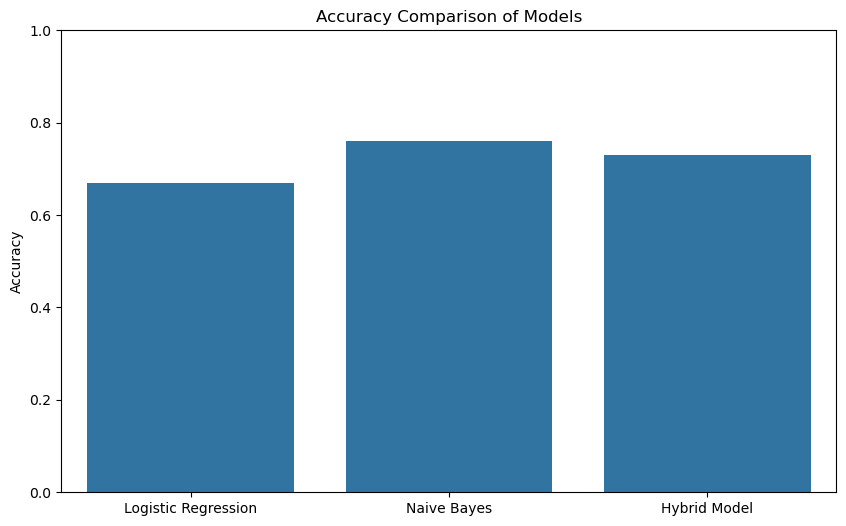

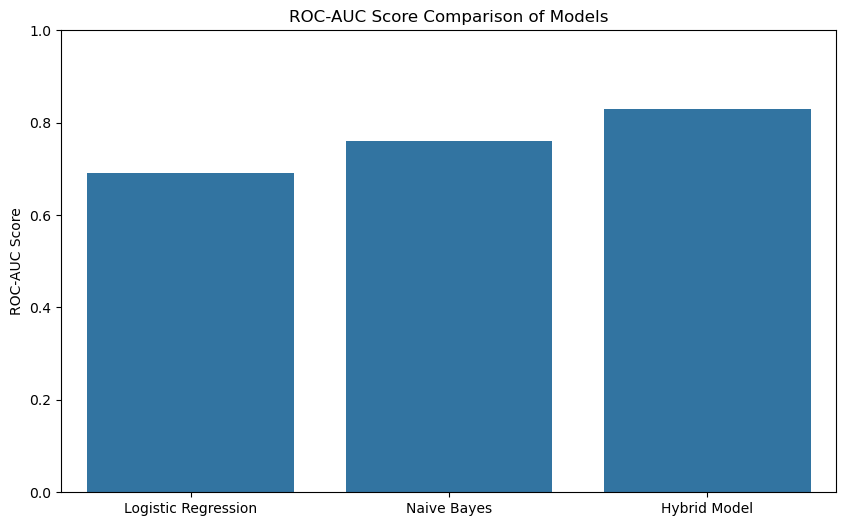

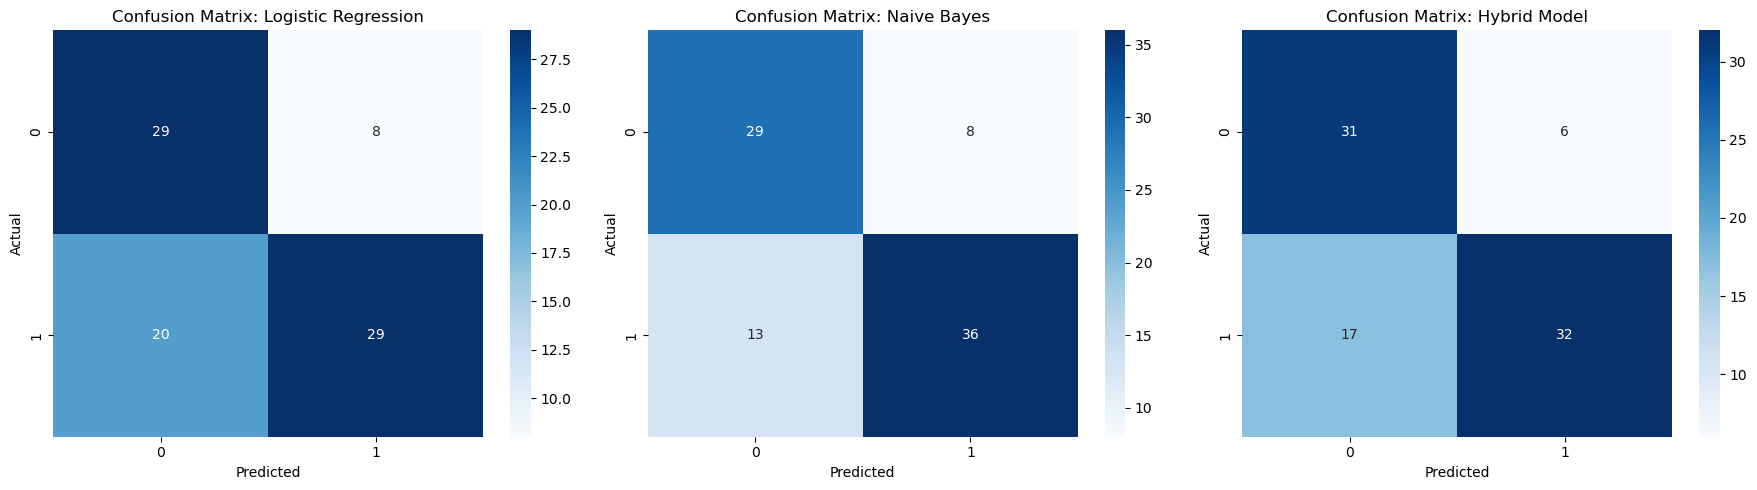

In [26]:
# Section 8: Visualize Results and Discuss Conclusions

# Model performance metrics
accuracies = [0.67, 0.76, 0.73]  # Accuracy of Logistic Regression, Naive Bayes, and Hybrid Model
ROC_AUC_scores = [0.69, 0.76, 0.83]  # ROC-AUC Score of Logistic Regression, Naive Bayes, and Hybrid Model
model_names = ['Logistic Regression', 'Naive Bayes', 'Hybrid Model']

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title('Accuracy Comparison of Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot ROC-AUC Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=ROC_AUC_scores)
plt.title('ROC-AUC Score Comparison of Models')
plt.ylabel('ROC-AUC Score')
plt.ylim(0, 1)
plt.show()

# Plot Confusion Matrices
conf_matrices = [
    [[29, 8], [20, 29]],  # Logistic Regression
    [[29,  8], [13, 36]],  # Naive Bayes
    [[31, 6], [17, 32]]    # Hybrid Model
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, cm in enumerate(conf_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {model_names[i]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()

The evaluation results demonstrate that the Naive Bayes model achieves the highest accuracy of 76%, significantly outperforming the Logistic Regression model, which attained an accuracy of 67%. The Hybrid Model, which combines both Logistic Regression and Naive Bayes, follows with a robust accuracy of 73%, indicating that the ensemble approach effectively leverages the strengths of the individual models. Beyond accuracy, the ROC-AUC (Receiver Operating Characteristic - Area Under Curve) scores provide a deeper understanding of each model's performance. The ROC-AUC score measures a model's ability to distinguish between positive and negative classes, with values closer to 1 indicating excellent discriminative power. In this context, Logistic Regression has a ROC-AUC score of 0.69, Naive Bayes matches it with 0.76, and the Hybrid Model excels further with an impressive 0.83.

These outcomes suggest that while Naive Bayes stands out as the most accurate individual model, the Hybrid Model offers superior overall performance by not only maintaining high accuracy but also enhancing the model's ability to differentiate between classes, as evidenced by its higher ROC-AUC score. The elevated ROC-AUC of the Hybrid Model indicates a stronger capacity to correctly rank positive instances above negative ones, making it particularly valuable for applications where distinguishing between classes is crucial. Conversely, Logistic Regression, despite its interpretability and foundational role in classification tasks, is less effective in capturing the complexities of the data compared to Naive Bayes and the Hybrid approach. Therefore, for scenarios demanding both high accuracy and robust class differentiation, the Hybrid Model emerges as the most effective choice, leveraging the complementary strengths of its constituent models to deliver enhanced predictive performance.

# Section 9: Executive Summary


### **Executive Summary**

In this project, we aimed to build a machine learning pipeline to predict whether a given video would be liked or not based on multiple features. We utilized both numerical and text data to develop and evaluate multiple classification models, including Logistic Regression, Naive Bayes, and a hybrid stacked model combining both. Below, we outline our key steps, summarize the pipeline, visualize results, and discuss key insights and future improvements.

### Steps Undertaken

1. **Data Preparation**: The dataset consisted of both numerical and textual features, such as view counts, like ratios, and video titles. We started by splitting the dataset into training and testing subsets.

2. **Preprocessing**: Different preprocessing techniques were applied based on the type of data. Numerical features were standardized, categorical features were one-hot encoded, and text features (title and topic category) were vectorized using CountVectorizer.

3. **Model Training**: Three models were created for comparison:
   - **Logistic Regression**: A standard model for predicting numerical outcomes, tuned using grid search to find optimal hyperparameters.
   - **Naive Bayes**: A model suited for text data, focusing on features like title and topic category.
   - **Hybrid Model**: An ensemble approach combining Logistic Regression and Naive Bayes by integrating their predicted probabilities, thereby leveraging their complementary strengths to enhance overall performance.

4. **Evaluation**: Each model was evaluated using accuracy and ROC-AUC scores. The results indicated that the Naive Bayes model and the hybrid model performed better compared to Logistic Regression, especially on metrics like ROC-AUC.

### Pipeline Diagram

![Pipeline Diagram](pipeline-diagram.jpg)



### Key Results and Visualizations

- **Accuracy**: The Logistic Regression model achieved an accuracy of **0.67**, while the Naive Bayes model outperformed it with an accuracy of **0.76**. The Hybrid Model followed with a respectable accuracy of **0.73**.

- **ROC-AUC Score**: The ROC-AUC scores provide a deeper understanding of each model's ability to distinguish between liked and not liked videos. The Logistic Regression model had a ROC-AUC score of **0.69**, indicating a fair discriminative ability. The Naive Bayes model improved this metric to **0.76**, demonstrating a good capacity to differentiate between classes. Impressively, the Hybrid Model achieved a ROC-AUC score of **0.83**, showcasing its superior ability to accurately rank positive instances higher than negative ones.

### Insights and Shortcomings

- **Naive Bayes Strength**: The Naive Bayes model showed promising results for text classification, performing well on the title and topic category features. Its higher accuracy and ROC-AUC score suggest effective handling of the textual data, likely due to its assumption of feature independence, which suited the dataset's characteristics.

- **Hybrid Model Excellence**: The Hybrid Model, which combines the strengths of both Logistic Regression and Naive Bayes, demonstrated a balanced performance with an accuracy of **0.73** and an outstanding ROC-AUC score of **0.83**. This indicates that the ensemble approach effectively leverages the complementary capabilities of the individual models, enhancing the overall discriminative power beyond what each model could achieve alone.

- **Logistic Regression Limitations**: While Logistic Regression is foundational and interpretable, it exhibited lower performance metrics with an accuracy of **0.67** and a ROC-AUC score of **0.69**. This suggests that, in this context, Logistic Regression was less effective in capturing the complexities of the data compared to Naive Bayes and the Hybrid approach.

- **Feature Representation**: The combination of numerical and text features through an ensemble approach highlighted the importance of leveraging diverse data types. However, the current feature representation might benefit from more sophisticated techniques, such as TF-IDF for text data or feature interactions for numerical data, to further enhance model performance.

### Improvements and Future Work

- **Model Complexity and Diversity**: Explore integrating additional diverse models into the ensemble, such as Support Vector Machines or Gradient Boosting classifiers, to potentially capture different aspects of the data and further improve performance.

- **Hyperparameter Optimization**: Conduct more extensive hyperparameter tuning using methods like RandomizedSearchCV or Bayesian Optimization to identify optimal settings that could enhance model performance.


This project demonstrated the effectiveness of combining multiple models to enhance classification performance on datasets comprising both textual and numerical data. The superior ROC-AUC score of the Hybrid Model underscores the potential of ensemble methods in achieving robust discriminative capabilities. Future improvements focusing on advanced feature engineering, model diversity, and optimization techniques hold promise for further elevating the model's performance and applicability.


# Section 10: References

Scikit-learn Documentation: The official Scikit-learn documentation was referenced for model building, hyperparameter tuning, and implementation of different machine learning models, including Logistic Regression, Naive Bayes, and Stacking Classifier.

Pandas Documentation: The Pandas documentation was used extensively for handling and preprocessing data.

Machine Learning Textbook: The course textbook, "Probabilistic Machine Learning" by Kevin Murphy, provided theoretical knowledge for understanding and implementing various machine learning models.

Stack Overflow: Various posts on Stack Overflow were used to troubleshoot issues with sklearn pipelines, data preprocessing, and feature engineering.